In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_image(fname):
    gray_img = cv2.imread(fname, 0)    # gray image
    bgr_img = cv2.imread(fname)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return gray_img, rgb_img

In [3]:
def gaussian_low_pass_filter(size_x, size_y, cutoff_ratio=0.5):
    H = np.zeros((size_x, size_y))
    cutoff = np.ceil(cutoff_ratio * 0.5 * size_x)
    if (size_x > size_y):
        cutoff = np.ceil(cutoff_ratio * 0.5 * size_y)
    center_x = int(size_x/2)
    center_y = int(size_y/2)
    for i in range(size_x):
        u = i-center_x
        for j in range(size_y):
            v = j-center_y
            H[i,j] = np.exp(-(u**2+v**2)/(2*(cutoff**2)))
#     print("low-pass-filter: {0}\n{1}".format(H.shape, H))
    return H

In [4]:
def get_magnitude_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift)+1)
    return magnitude_spectrum, fshift

In [5]:
def img_back(fimage):
    fshift  = np.fft.ifftshift(fimage)
    img = np.fft.ifft2(fshift)
    img = img.real
    return img

In [6]:
def float_to_int(data):
    new_data = (data).astype(np.uint8)
    return new_data

In [7]:
def plot_img(img_1, img_2, camp=None):
    fig, ax = plt.subplots(1,2, figsize=[8, 6])
    ax[0].axis('off')
    ax[1].axis('off')
    ax[0].imshow(img_1, cmap = camp)
    ax[1].imshow(img_2, cmap = camp)

In [8]:
def cv_save(fname, img):
    cv2.imwrite(fname, img)

In [9]:
def down_sample(img):
    sub_img = np.zeros((int(img.shape[0]/2), int(img.shape[1]/2)))
    for i in range(0, img.shape[0], 2):
        if i+1>=img.shape[0]:
            break
        i1 = i
        i2 = i+1
        for j in range(0, img.shape[1], 2):
            if j+1>=img.shape[1]:
                break
            j1 = j
            j2 = j+1
            sub_img[int(i/2), int(j/2)] = (img[i1, j1]+img[i1, j2]+img[i2, j1]+img[i2, j2])/4
    return sub_img

In [10]:
def interpolation(img, shape, method='BICUBIC'):
    if method == 'NEAREST':
        expand = nearest_neighbor_interpolation(img, shape)
        expand_spec, _ = get_magnitude_spectrum(expand)
        return expand, expand_spec
    elif method == 'BILINEAR':
        expand = nearest_neighbor_interpolation(img, shape)
        expand_spec, _ = get_magnitude_spectrum(expand)
        return expand, expand_spec
    elif method == 'BICUBIC':
        expand = nearest_neighbor_interpolation(img, shape)
        expand_spec, _ = get_magnitude_spectrum(expand)
        return expand, expand_spec

In [11]:
def nearest_neighbor_interpolation(img, shape):
    h = img.shape[0]
    w = img.shape[1]
    expand = np.zeros((shape[0], shape[1]))
    for i in range(shape[0]):
        for j in range(shape[1]):
            x = round(i*h/shape[0])
            y = round(j*w/shape[1])
            if x >= h:
                x = h-1
            if y >= w:
                y = w-1
            expand[i, j] = img[x, y]
    return expand

In [12]:
def gaussian_pyramid(img):
    img_spec, fshift = get_magnitude_spectrum(img)
    gaussian_filter = gaussian_low_pass_filter(img.shape[0], img.shape[1])
    gaussian_spec = img_spec * gaussian_filter
    gaussian_f = fshift * gaussian_filter
    gaussian_img = img_back(gaussian_f)
    pyramid_img = down_sample(gaussian_img)
    pyramid_spec, _ = get_magnitude_spectrum(pyramid_img)
    return img, img_spec, pyramid_img, pyramid_spec

In [13]:
def laplacian_pyramid(origin, expand):
    p_img = origin - expand
    img_spec, _ = get_magnitude_spectrum(p_img)
    plot_img(p_img, img_spec, 'gray')

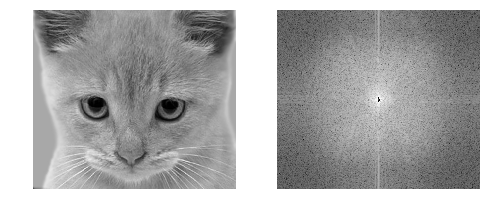

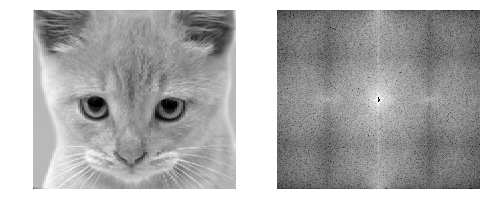

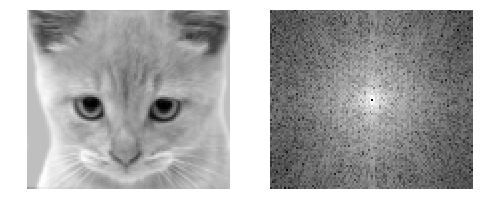

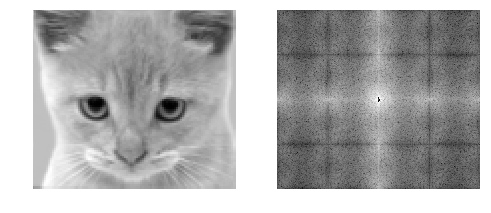

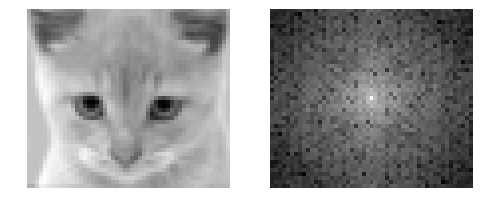

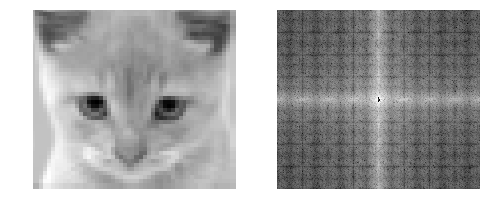

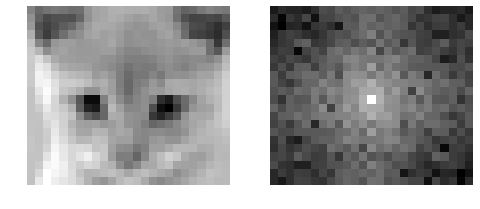

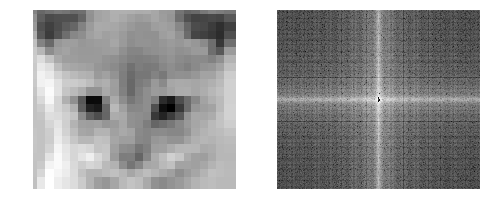

In [14]:
fname = 'cat'
ftype = 'bmp'
img, _ = read_image('./hw2_data/task1and2_hybrid_pyramid/'+fname+'.'+ftype)
shape = img.shape

origin, origin_spec, img, img_spec = gaussian_pyramid(img)
plot_img(origin, float_to_int(origin_spec), 'gray')
cv_save('./task2/'+fname+'.jpg', origin)
cv_save('./task2/'+fname+'_pyramid_1.jpg', img)

expand, expand_spec = interpolation(img, shape, method='NEAREST')
cv_save('./task2/'+fname+'_expand_1.jpg', expand)
plot_img(float_to_int(expand), float_to_int(expand_spec), 'gray')

for i in range(2, 5):
    origin, origin_spec, img, img_spec = gaussian_pyramid(img)
    plot_img(img, float_to_int(img_spec), 'gray')
    cv_save('./task2/'+fname+'_pyramid_'+str(i)+'.jpg', img)
    
    expand, expand_spec = interpolation(img, shape, method='NEAREST')
    cv_save('./task2/'+fname+'_expand_'+str(i)+'.jpg', expand)
    plot_img(float_to_int(expand), float_to_int(expand_spec), 'gray')
# laplacian_pyramid(origin, img)